In [1]:
from PIL import Image
import numpy as np 
import os 


import numpy as np
import matplotlib.pyplot as pl
import torch
import ot
import ot.plot

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Enable interactive mode
%matplotlib ipympl
os.environ["CUDA_VISIBLE_DEVICES"] = "1" # has not effect

import sys
sys.path.append("../")
device="cuda"
from tqdm import tqdm_notebook as tqdm

from gaussian_renderer import render, network_gui
from arguments import ModelParams, PipelineParams, OptimizationParams
import argparse
from scene import Scene, GaussianModel
from random import randint
from argparse import ArgumentParser, Namespace

In [2]:
saving_steps = [1, 100, 300, 1_000, 3_000, 7_000, 10_000, 15_000, 20_000, 30_000]
parser = ArgumentParser(description="Training script parameters")
lp = ModelParams(parser)
op = OptimizationParams(parser)
pp = PipelineParams(parser)
parser.add_argument('--ip', type=str, default="127.0.0.1")
parser.add_argument('--port', type=int, default=6009)
parser.add_argument('--debug_from', type=int, default=-1)
parser.add_argument('--detect_anomaly', action='store_true', default=False)
parser.add_argument("--test_iterations", nargs="+", type=int, default=saving_steps)
parser.add_argument("--save_iterations", nargs="+", type=int, default=saving_steps)
parser.add_argument("--quiet", action="store_true")
parser.add_argument("--checkpoint_iterations", nargs="+", type=int, default=saving_steps)# default=[])
parser.add_argument("--start_checkpoint", type=str, default = None)
args = parser.parse_args(("-s /home/dimakot55/data/nerf_synthetic/hotdog/ "+\
                         "--model_path /home/dimakot55/workspace/gaussian-splatting/notebooks/GT_lego_cluster2_test_notebook14/").split())#sys.argv[1:])
#args.save_iterations.append(args.iterations)
dataset=lp.extract(args)
pipe=pp.extract(args)
opt=op.extract(args)
os.makedirs(args.model_path, exist_ok=True)

In [3]:
os.makedirs(args.model_path, exist_ok=True)
content_gaussians = GaussianModel(3)
content_scene = Scene(dataset, content_gaussians, shuffle=True)
content_gaussians.training_setup(opt)

Found transforms_train.json file, assuming Blender data set!
Reading Training Transforms
Reading Test Transforms
Loading Training Cameras
Loading Test Cameras
Number of points at initialisation :  100000


In [386]:

# content_gaussians.restore(torch.load("/home/dimakot55/output_data/gs_fitted/gs_fitted/GT_hotdog_spheres/chkpnt30000.pth")[0], opt)
# content_gaussians.restore(torch.load("/home/dimakot55/output_data/gs_fitted/gs_fitted/GT_hotdog/chkpnt30000.pth")[0], opt)
content_gaussians.restore(torch.load("/home/dimakot55/output_data/gs_my/gs/GT_hotdog/chkpnt30000.pth")[0], opt)

In [387]:
content_gaussians_features_ds_original = content_gaussians._features_dc.detach().clone()

In [388]:
content_gaussians._features_dc.data = content_gaussians._xyz.data.clone().detach().unsqueeze(1)
content_gaussians._features_rest.data = content_gaussians._features_rest.data * 0.

In [389]:

bg_color = [1, 1, 1] if dataset.white_background else [0, 0, 0]
background = torch.tensor(bg_color, dtype=torch.float32, device=device)
viewpoint_stack = content_scene.getTrainCameras().copy()
viewpoint_cam = viewpoint_stack.pop(randint(0, len(viewpoint_stack)-1))



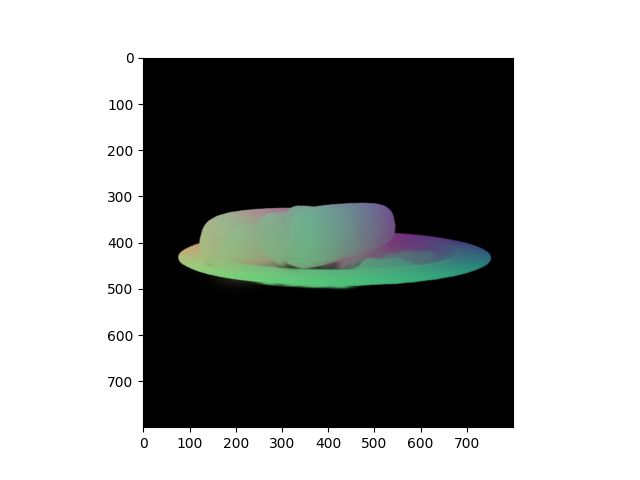

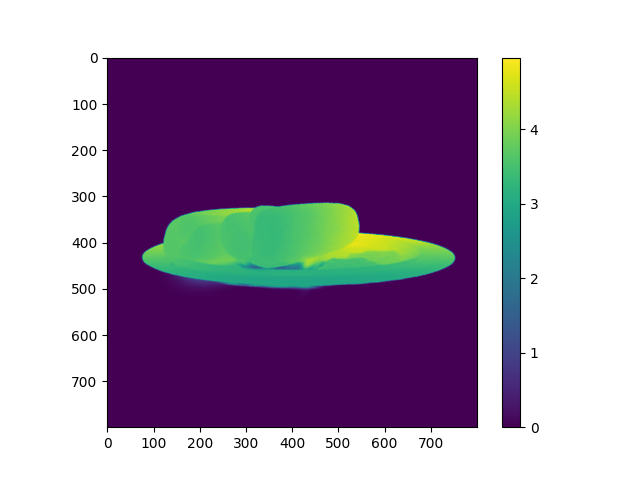

In [390]:

render_pkg_cont = render(viewpoint_cam, content_gaussians, pipe, background)
image_cont, depth_cont= render_pkg_cont["render"], render_pkg_cont["depth"]

image_rgb = image_cont.detach().cpu().numpy().transpose(1, 2, 0)
plt.figure()
plt.imshow(image_rgb)
plt.show()


depth_np = depth_cont.detach().cpu().numpy()

plt.figure()
plt.imshow(depth_np)
plt.colorbar()
plt.show()


In [391]:

viewpoint_stack = content_scene.getTrainCameras().copy()
viewpoint_cam = viewpoint_stack.pop(randint(0, len(viewpoint_stack)-1))

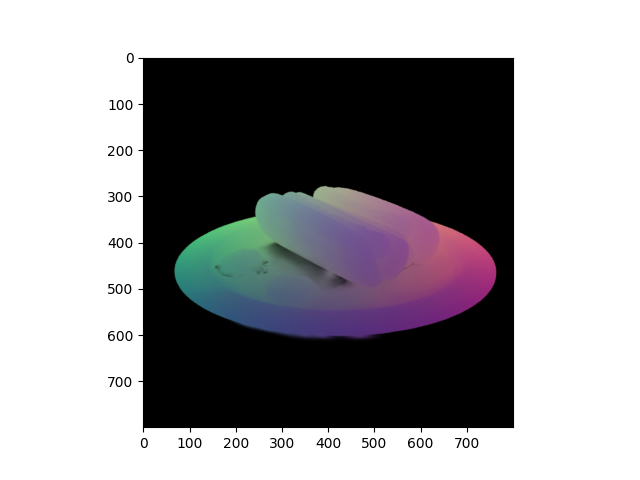

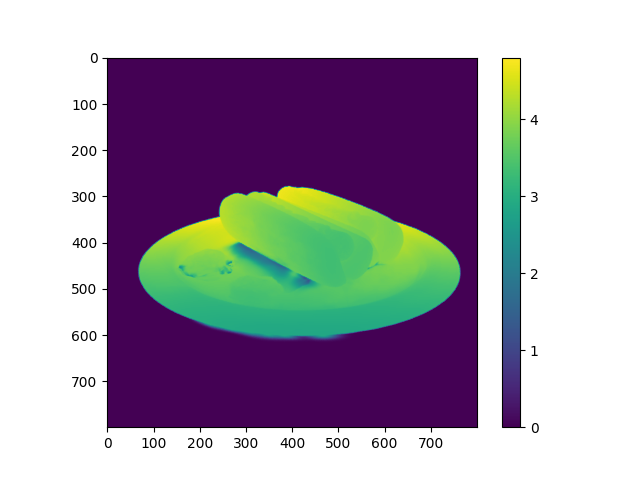

In [392]:

render_pkg_cont = render(viewpoint_cam, content_gaussians, pipe, background)
image_cont, depth_cont= render_pkg_cont["render"], render_pkg_cont["depth"]

image_rgb = image_cont.detach().cpu().numpy().transpose(1, 2, 0)
plt.figure()
plt.imshow(image_rgb)
plt.show()


depth_np = depth_cont.detach().cpu().numpy()

plt.figure()
plt.imshow(depth_np)
plt.colorbar()
plt.show()


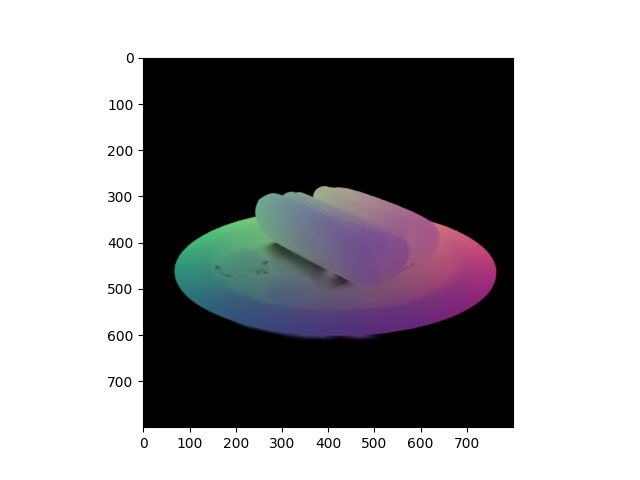

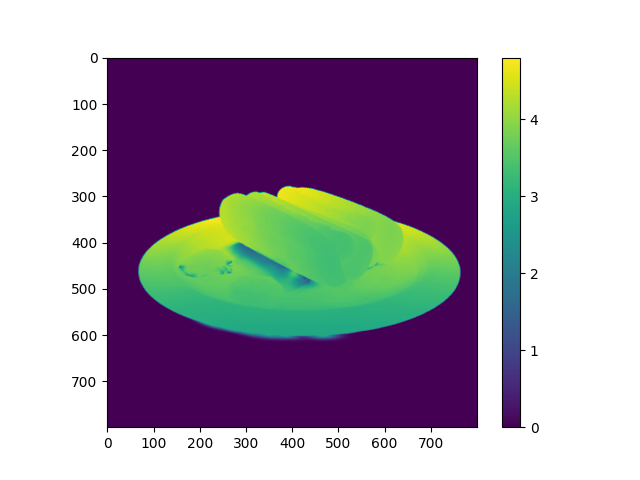

In [393]:

render_pkg_cont = render(viewpoint_cam, content_gaussians, pipe, background)
image_cont, depth_cont= render_pkg_cont["render"], render_pkg_cont["depth"]

image_rgb = image_cont.detach().cpu().numpy().transpose(1, 2, 0)
plt.figure()
plt.imshow(image_rgb)
plt.show()


depth_np = depth_cont.detach().cpu().numpy()

plt.figure()
plt.imshow(depth_np)
plt.colorbar()
plt.show()


# Sample cameras  and transform color into coordinates. (if depth > 0)

In [394]:
# content_gaussians._scaling.data *=  .98
content_gaussians._opacity.data +=  1e6


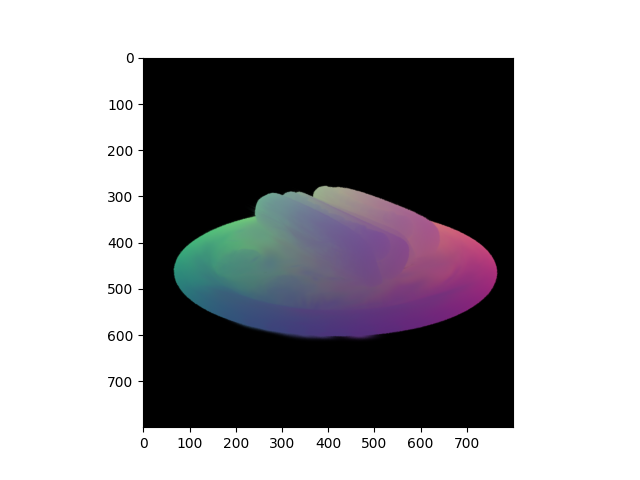

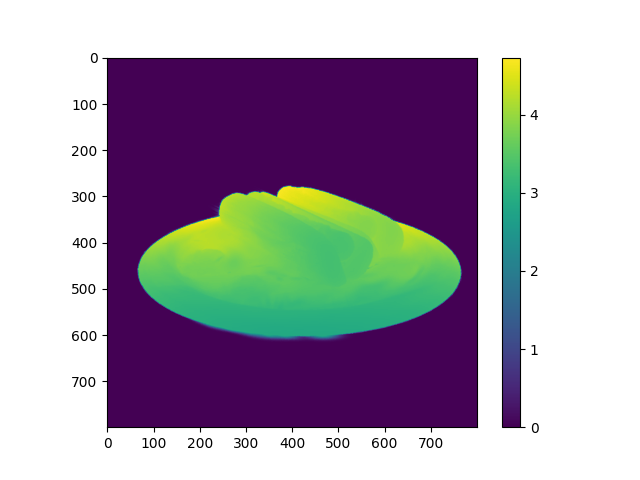

In [395]:

render_pkg_cont = render(viewpoint_cam, content_gaussians, pipe, background)
image_cont, depth_cont= render_pkg_cont["render"], render_pkg_cont["depth"]

image_rgb = image_cont.detach().cpu().numpy().transpose(1, 2, 0)
plt.figure()
plt.imshow(image_rgb)
plt.show()


depth_np = depth_cont.detach().cpu().numpy()

plt.figure()
plt.imshow(depth_np)
plt.colorbar()
plt.show()


In [396]:
all_points = []

In [349]:


# viewpoint_stack = content_scene.getTrainCameras().copy()
# viewpoint_cam = viewpoint_stack.pop(randint(0, len(viewpoint_stack)-1))
render_pkg_cont = render(viewpoint_cam, content_gaussians, pipe, background)
image_cont, depth_cont= render_pkg_cont["render"], render_pkg_cont["depth"]

image_visibility = render_pkg_cont["visibility_filter"] 
image_rgb = image_cont.detach().cpu().numpy().transpose(1, 2, 0)
depth_np = depth_cont.detach().cpu().numpy()

# all_points += list(image_rgb[np.where(depth_np > 0)[0]])
all_points += list(image_rgb[np.min(image_rgb, axis=-1)>0.1])





In [350]:
import numpy as np
import skimage.measure, skimage.morphology
import scipy

image_rgb_maxpool4x4 = skimage.measure.block_reduce(image_rgb, (3,3,1), np.max)

mask = scipy.ndimage.binary_erosion(np.max(image_rgb_maxpool4x4, axis=-1) > 0.1, structure=None, iterations=5)
image_clean = image_rgb_maxpool4x4 * np.expand_dims(mask, axis=-1)

# image_rgb_maxpool4x4 = skimage.morphology.binary_erosion(np.max(image_rgb_maxpool4x4, axis=-1) > 0. , (3,3))

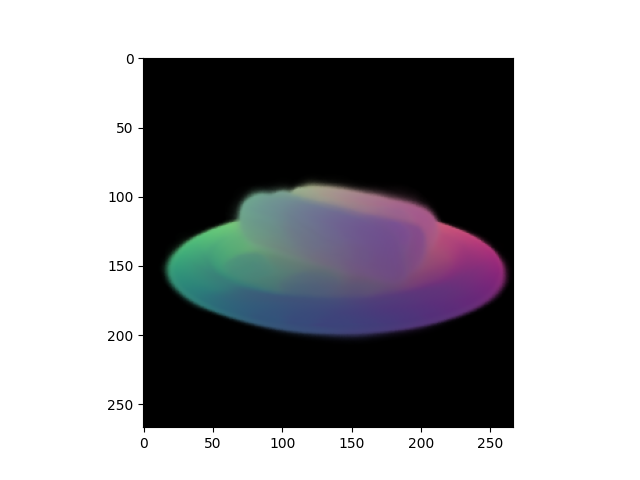

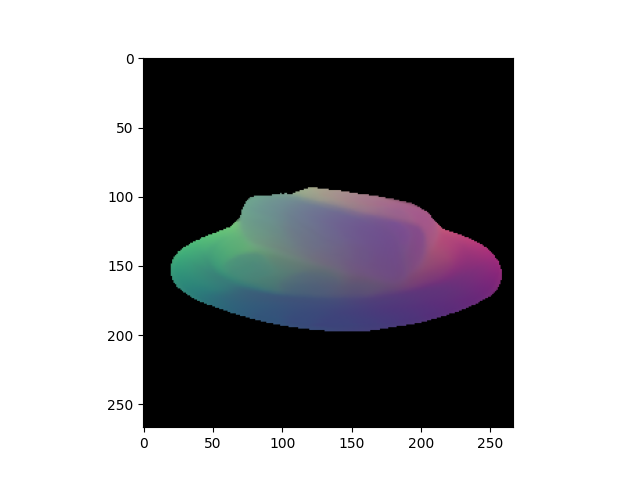

ValueError: operands could not be broadcast together with shapes (800,800,3) (267,267,3) 

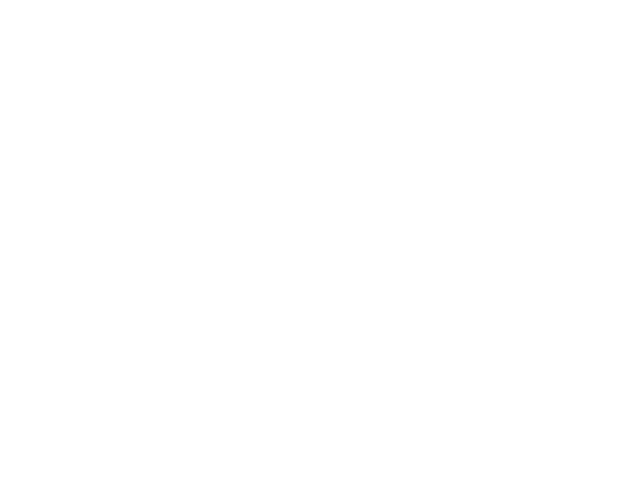

In [351]:
plt.figure()
plt.imshow(image_rgb_maxpool4x4)
plt.show()


plt.figure()
plt.imshow(image_clean)
plt.show()



plt.figure()
plt.imshow(image_rgb - image_clean)
plt.show()

In [261]:
all_points = list(image_clean[np.min(image_clean, axis=-1)>0.01])
all_points = np.array(all_points)

In [262]:
all_points = np.array(all_points)

In [198]:
np.random.choice(len(all_points), size=subset_size, replace=False)

array([ 8300, 15168,  8869, ...,  4580,  2071,  5314])

In [199]:
# sample a subset of poitns



subset_size = 5000  # Specify the size of the subset
all_points = all_points[np.random.choice(len(all_points), size=subset_size, replace=False)]

In [200]:
# 1. Remove poitns that are too far away from all other points. These are just noise
# Compute all pairwise distances between points
from scipy.spatial import distance
k=10
pairwise_distances = distance.cdist(all_points, all_points, 'euclidean')
# Use np.partition to find the k-th smallest distances for each row
kth_nearest_indices = np.argpartition(pairwise_distances, k, axis=1)[:, :k]
kth_nearest_distances = np.take_along_axis(pairwise_distances, kth_nearest_indices, axis=1)
q_outliers = np.quantile(np.max(kth_nearest_distances, axis=-1), 0.98)
idcs = np.where(np.max(kth_nearest_distances, axis=-1) < q_outliers)[0]
all_points = all_points[idcs]


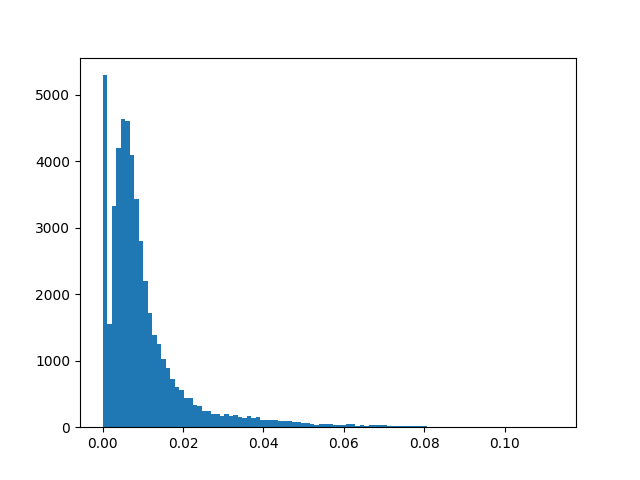

In [201]:
plt.figure()
plt.hist(kth_nearest_distances.flatten(), bins=100)
plt.show()

In [202]:
all_points.shape

(4899, 3)

In [203]:

# Functions from @Mateen Ulhaq and @karlo for visualizing 3d points with equal scaling of axes
def set_axes_equal(ax: plt.Axes):
    """Set 3D plot axes to equal scale.

    Make axes of 3D plot have equal scale so that spheres appear as
    spheres and cubes as cubes.  Required since `ax.axis('equal')`
    and `ax.set_aspect('equal')` don't work on 3D.
    """
    limits = np.array([
        ax.get_xlim3d(),
        ax.get_ylim3d(),
        ax.get_zlim3d(),
    ])
    origin = np.mean(limits, axis=1)
    radius = 0.5 * np.max(np.abs(limits[:, 1] - limits[:, 0]))
    _set_axes_radius(ax, origin, radius)

def _set_axes_radius(ax, origin, radius):
    x, y, z = origin
    ax.set_xlim3d([x - radius, x + radius])
    ax.set_ylim3d([y - radius, y + radius])
    ax.set_zlim3d([z - radius, z + radius])



In [418]:

def obtain_surface_pc(viewpoint_stack, gaussians, pipe, background, num_viewpoints=40, pc_size=20000):
    import numpy as np
    import skimage.measure, skimage.morphology
    import scipy

    # 1. Render from different viewpoints and extract points
    all_points = []
    for iter in range(min(num_viewpoints, len(viewpoint_stack))):
        viewpoint_cam = viewpoint_stack.pop(randint(0, len(viewpoint_stack)-1))
        render_pkg_cont = render(viewpoint_cam, gaussians, pipe, background)
        image = render_pkg_cont["render"]
        image_rgb = image.detach().cpu().numpy().transpose(1, 2, 0)
        image_maxpool = skimage.measure.block_reduce(image_rgb, (3,3,1), np.max)
        mask = scipy.ndimage.binary_erosion(np.max(image_maxpool, axis=-1) > 0.1, structure=None, iterations=5)
        image_clean = image_maxpool * np.expand_dims(mask, axis=-1)
        all_points += list(image_clean[np.min(image_clean, axis=-1)>0.1])
    
    
    # 2. Subsample the points 
    all_points = np.array(all_points)
    all_points_idcs = np.random.choice(range(len(all_points)), size=pc_size, replace=False) 
    all_points = all_points[all_points_idcs]

    # 3. Remove poitns that are too far away from all other points.
    # Compute all pairwise distances between points
    from scipy.spatial import distance
    k=10
    pairwise_distances = distance.cdist(all_points, all_points, 'euclidean')
    # Use np.partition to find the k-th smallest distances for each row
    kth_nearest_indices = np.argpartition(pairwise_distances, k, axis=1)[:, :k]
    kth_nearest_distances = np.take_along_axis(pairwise_distances, kth_nearest_indices, axis=1)
    q_outliers = np.quantile(np.max(kth_nearest_distances, axis=-1), 0.99)
    idcs = np.where(np.max(kth_nearest_distances, axis=-1) < q_outliers)[0]
    all_points = all_points[idcs]
    return all_points
                

In [419]:
viewpoint_stack = content_scene.getTrainCameras().copy()
all_points = obtain_surface_pc(viewpoint_stack=viewpoint_stack, 
                               gaussians=content_gaussians, 
                               pipe=pipe, 
                               background=background,
                               num_viewpoints=40)

#np.random.choice(len(all_points), size=subset_size, replace=False)

In [420]:
all_points.shape

(19800, 3)

In [412]:
all_points_idcs = np.random.choice(range(len(all_points)), size=20000, replace=False) 
all_points = all_points[all_points_idcs]

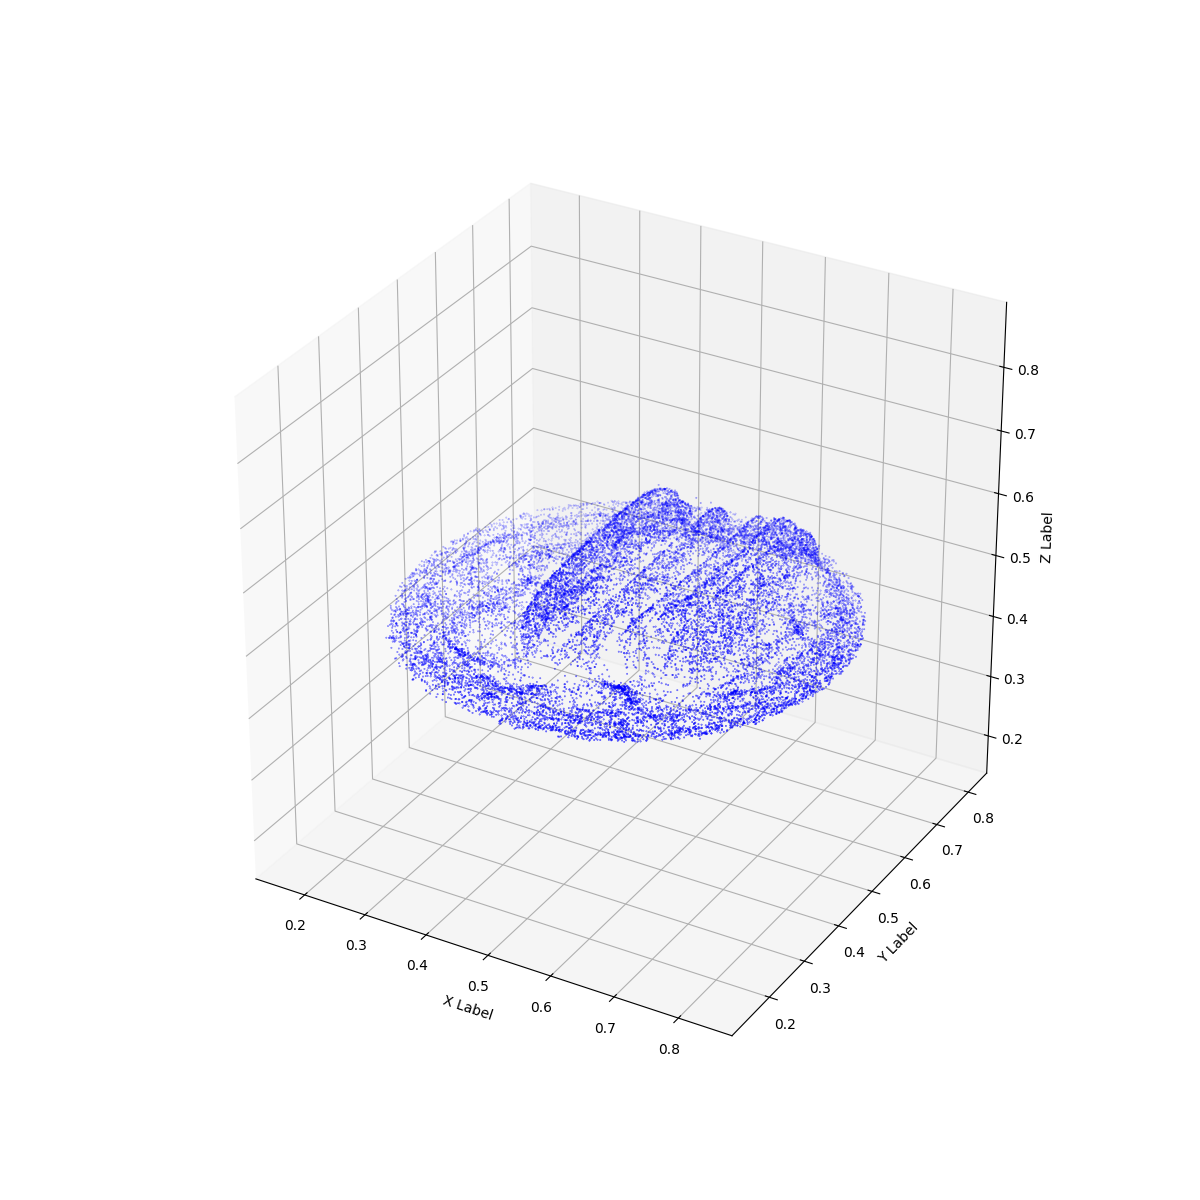

In [421]:
# Create a 3D scatter plot
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')
#ax.axis('equal')
ax.set_aspect('equal')
# Plot target shape

# Plot the scatter points
kth=1
if True:
    arr_shape = all_points
    ax.scatter(arr_shape[::kth,0], 
               arr_shape[::kth,1], 
               arr_shape[::kth,2], c='b', marker='o',s=0.1)



# Set labels for the axes
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

ax.set_box_aspect([1,1,1]) # IMPORTANT - this is the new, key line
# ax.set_proj_type('ortho') # OPTIONAL - default is perspective (shown in image above)
set_axes_equal(ax) # IMPORTANT - this is also required
plt.show()

In [414]:
# 1. Remove poitns that are too far away from all other points. These are just noise
# Compute all pairwise distances between points
from scipy.spatial import distance
k=10
pairwise_distances = distance.cdist(all_points, all_points, 'euclidean')
# Use np.partition to find the k-th smallest distances for each row
kth_nearest_indices = np.argpartition(pairwise_distances, k, axis=1)[:, :k]
kth_nearest_distances = np.take_along_axis(pairwise_distances, kth_nearest_indices, axis=1)
q_outliers = np.quantile(np.max(kth_nearest_distances, axis=-1), 0.99)
idcs = np.where(np.max(kth_nearest_distances, axis=-1) < q_outliers)[0]
all_points = all_points[idcs]


In [415]:
all_points.shape

(19800, 3)

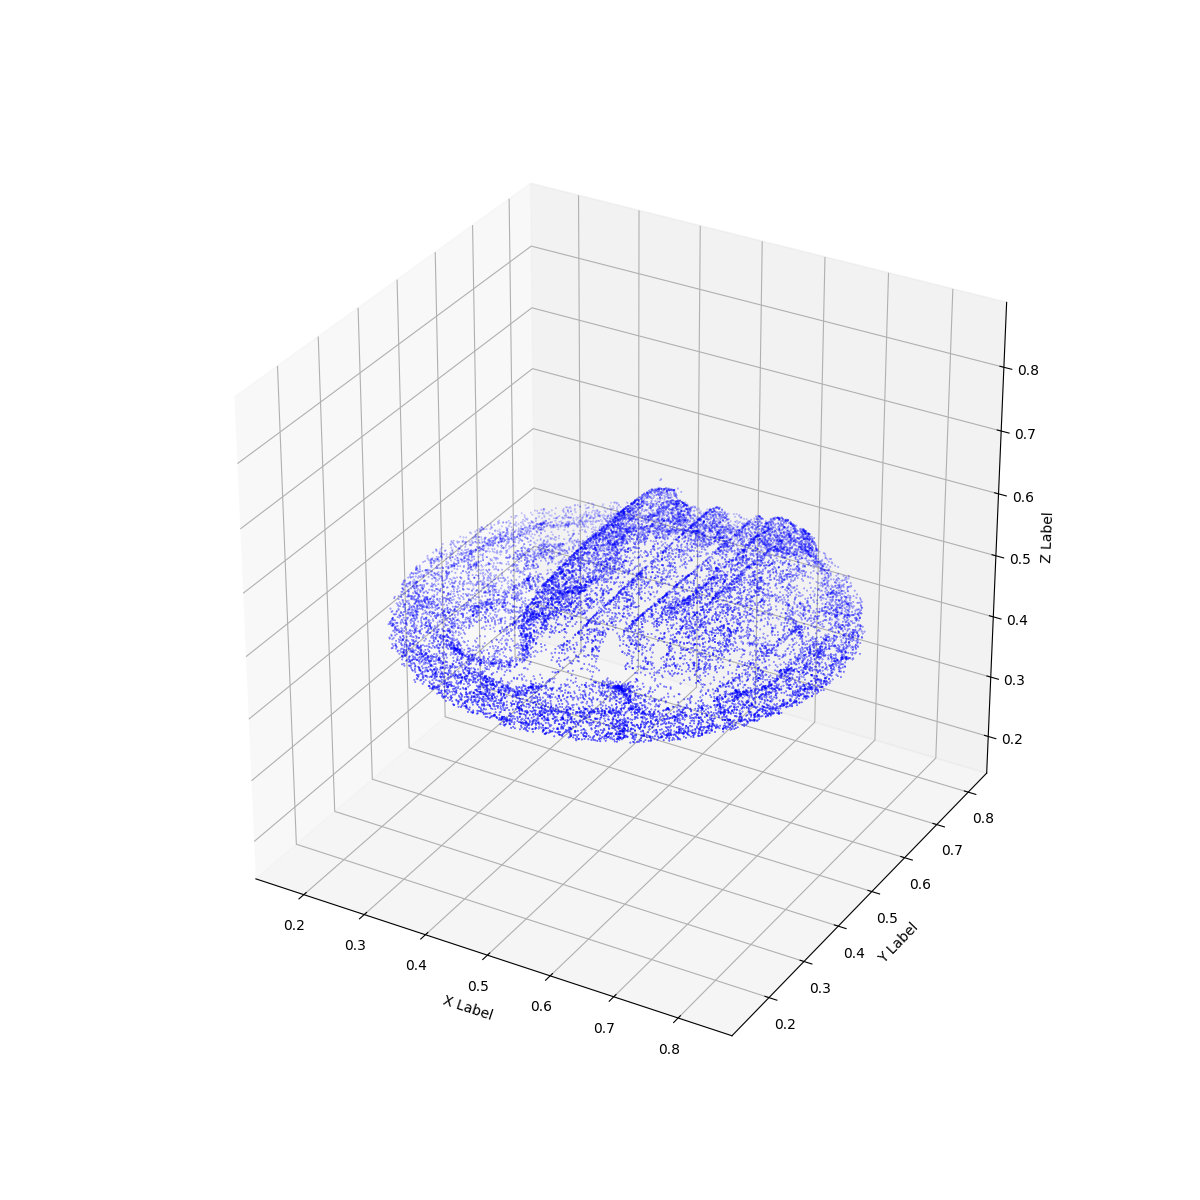

In [416]:
# Create a 3D scatter plot
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')
#ax.axis('equal')
ax.set_aspect('equal')
# Plot target shape

# Plot the scatter points
kth=1
if True:
    arr_shape = all_points
    ax.scatter(arr_shape[::kth,0], 
               arr_shape[::kth,1], 
               arr_shape[::kth,2], c='b', marker='o',s=0.1)



# Set labels for the axes
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

ax.set_box_aspect([1,1,1]) # IMPORTANT - this is the new, key line
# ax.set_proj_type('ortho') # OPTIONAL - default is perspective (shown in image above)
set_axes_equal(ax) # IMPORTANT - this is also required
plt.show()

In [17]:
np.where(depth_np > 0)[0]

array([214, 214, 214, ..., 698, 698, 698])

In [15]:
all_points[0].shape

(800, 3)

# Style patch loading

In [9]:

import torch
import torch.nn.functional as F
from scipy.spatial import distance
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA


def sample_points_by_density(points, num_samples=None, radius = 0.05, device='cuda'):
    """
    Samples points inversely proportional to their density in the neighborhood.
    :param points: torch tensor of shape [N,3]
    :param num_samples: Number of samples to be drawn according to the
        distribution of densities. If None, then we sample 1/10th of the points.
    :param radius: Radius of the local region around each point at which we compute
        the number of neighbors.
    :param device: Device on which the tensors are stored and computations will be done.
    :return: A torch tensor of shape [num_samples] containing the indices of the sampled points
    """


    # Assuming you have a PyTorch tensor of shape [N, 3] representing points
    # Calculate pairwise distances between all points
    # Note that i only compute distance to every 10th neighbor.
    distances = torch.cdist(points, points[::10])


    # Calculate the number of points within the local region for each point
    num_points_in_local_region = (distances <= radius).sum(dim=1)

    # Calculate the inverse density as a weight
    inverse_density = 1.0 / (num_points_in_local_region + 1)  # Add 1 to avoid division by zero

    # Normalize the weights to create a probability distribution
    probability_distribution = inverse_density / inverse_density.sum()

    # Sample points inversely proportional to their density
    if num_samples is None:
        num_samples = len(points) // 10  # Adjust the number of samples as needed
    sampled_indices = torch.multinomial(probability_distribution, num_samples, replacement=True)

    return sampled_indices
    
def remove_outliers(points, kth_neighbor=30, q=0.925, device='cuda'):
    """
    Removes outliers from the given points. Usually the set of clusters must be small to avoid
    quadratic complexity of the all pairwise neighbors computation.
    :param points: torch tensor of shape [N, 3]
    :param kth_neighbor: this neighbor we use to approximate good neighborhood density.
    :param q: Quantile to use for removing outliers.
    :param device: Device on which the tensors are stored and computations will be done.
    :return: A torch tensor of shape [N] containing the indices of the non-outlier points.
    """

    pairwise_distances = torch.cdist(points, points)
    kth_nearest_dists, kth_nearest_indices = torch.topk(pairwise_distances, k=kth_neighbor, dim=1, largest=False, sorted=True)
    q_outliers = torch.quantile(kth_nearest_dists[:, kth_neighbor-1], q=q)
    indcs_relevant = torch.where(kth_nearest_dists[:, kth_neighbor-1] < q_outliers)[0]
    return indcs_relevant

def prepare_scene(points, num_clusters=40, num_samples=None, radius=0.05, q=0.925, device='cuda'):
    """
    Prepares the scene by sampling points and clustering them.
    :param points: torch tensor of shape [N, 3]
    :param num_clusters: Number of clusters to use for KMeans clustering.
    :param num_samples: Number of samples to be drawn according to the
        distribution of densities. If None, then we sample 1/10th of the points from EACH cluster
    :param radius: Radius of the local region around each point at which we compute
        the number of neighbors.
    :param device: Device on which the tensors are stored and computations will be done.
    :return: A tuple containing the following tensors:
    """

     # Use KMeans clustering to find the centroids of the clusters
    kmeans = KMeans(init="k-means++", n_clusters=num_clusters, n_init=4)
    kmeans.fit(points.detach().cpu().numpy())
    clean_indices = []
    for lbls in np.unique(kmeans.labels_):
        cluster_points_idcs = np.where(kmeans.labels_ == lbls)[0]
        # Remove outliers
        non_outliers_idcs = remove_outliers(points[cluster_points_idcs], q=q, device=device)
        cluster_points_idcs = cluster_points_idcs[non_outliers_idcs.cpu().numpy()]
        # Sample points inversely proportional to the density
        sampled_idcs = sample_points_by_density(points[cluster_points_idcs], num_samples, radius, device)
        cluster_points_idcs = cluster_points_idcs[sampled_idcs.cpu().numpy()]
        clean_indices.append(cluster_points_idcs)

    return clean_indices, kmeans.cluster_centers_, kmeans.labels_[np.concatenate(clean_indices)]


In [11]:
content_shape_idcs, content_shape_cluster_centers, content_shape_cluster_labels = prepare_scene(
    points=content_gaussians._xyz,
    num_samples=None,
    radius=0.035,
    q=0.975, #0.975,
    num_clusters=80,
    device=device)


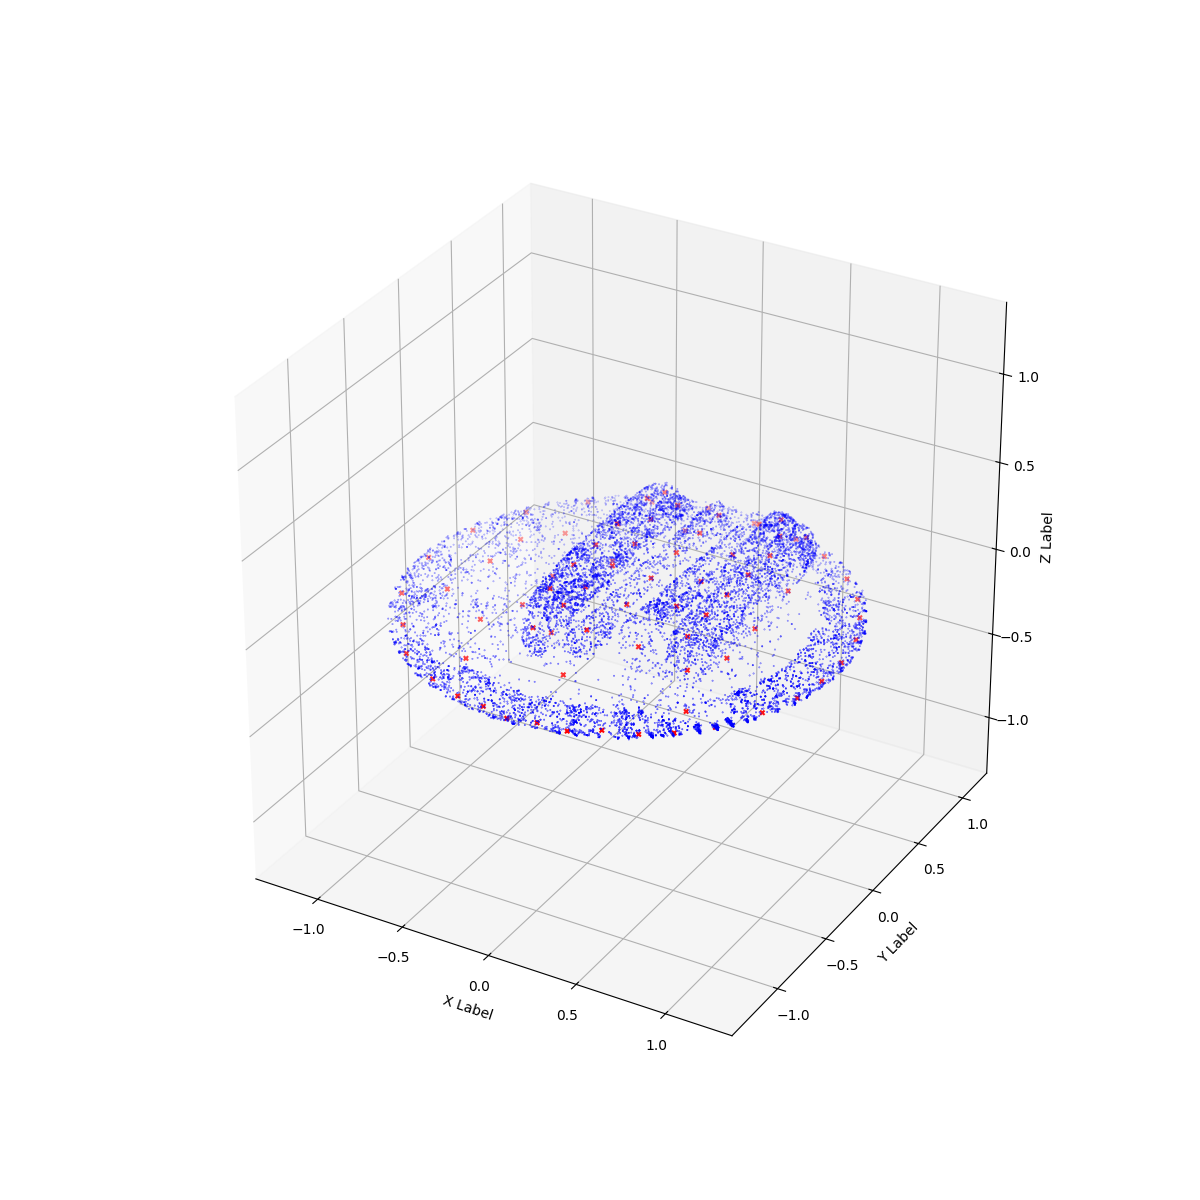

In [12]:

# Functions from @Mateen Ulhaq and @karlo for visualizing 3d points with equal scaling of axes
def set_axes_equal(ax: plt.Axes):
    """Set 3D plot axes to equal scale.

    Make axes of 3D plot have equal scale so that spheres appear as
    spheres and cubes as cubes.  Required since `ax.axis('equal')`
    and `ax.set_aspect('equal')` don't work on 3D.
    """
    limits = np.array([
        ax.get_xlim3d(),
        ax.get_ylim3d(),
        ax.get_zlim3d(),
    ])
    origin = np.mean(limits, axis=1)
    radius = 0.5 * np.max(np.abs(limits[:, 1] - limits[:, 0]))
    _set_axes_radius(ax, origin, radius)

def _set_axes_radius(ax, origin, radius):
    x, y, z = origin
    ax.set_xlim3d([x - radius, x + radius])
    ax.set_ylim3d([y - radius, y + radius])
    ax.set_zlim3d([z - radius, z + radius])


# Create a 3D scatter plot
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')
#ax.axis('equal')
ax.set_aspect('equal')
# Plot target shape

# Plot the scatter points
kth=1
if True:
    arr_shape = content_gaussians._xyz[np.concatenate(content_shape_idcs, axis=0)].detach().cpu().numpy()
    ax.scatter(arr_shape[::kth,0], 
               arr_shape[::kth,1], 
               arr_shape[::kth,2], c='b', marker='o',s=0.1)

ax.scatter(content_shape_cluster_centers[:, 0],
           content_shape_cluster_centers[:, 1],
           content_shape_cluster_centers[:, 2],
           c='r', marker='x', s=10.)

# Set labels for the axes
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

ax.set_box_aspect([1,1,1]) # IMPORTANT - this is the new, key line
# ax.set_proj_type('ortho') # OPTIONAL - default is perspective (shown in image above)
set_axes_equal(ax) # IMPORTANT - this is also required
plt.show()



# Cluster loading and preparation

In [13]:

loaded_data = np.load("/home/dimakot55/output_data/gs/GT_lego_spheres_v5_clusters_100/cluster_51.npz") # 51, 36, 49, 24, 40, 57, 45, 22, 20, 3, 32, 25,  19, 16, 17, 15, 13, 14

#loaded_data = np.load("/home/dimakot55/output_data/gs_my/GT_brickwall_spheres_clusters_50/cluster_14.npz") # 51, 36, 49, 24, 40, 57, 45, 22, 20, 3, 32, 25,  19, 16, 17, 15, 13, 14

# Access the arrays by their names
gaussians_xyz = loaded_data['_xyz']
gaussians_features_dc = loaded_data['_features_dc']
gaussians_features_rest = loaded_data['_features_rest']
gaussians_rotation = loaded_data['_rotation']
gaussians_scaling = loaded_data['_scaling']
gaussians_opacity = loaded_data['_opacity']

# 0. only for the bricks scene. Remove poitns underneath. and change size to smaller scale. Multiply coordinates and sizes.
idcs = np.where(gaussians_xyz[:,2]>-0.12)[0]
gaussians_xyz = gaussians_xyz[idcs]
gaussians_features_dc = gaussians_features_dc[idcs]
gaussians_features_rest = gaussians_features_rest[idcs]
gaussians_rotation = gaussians_rotation[idcs]
gaussians_scaling = gaussians_scaling[idcs]
gaussians_opacity = gaussians_opacity[idcs]




# 1. Remove poitns that are too far away from all other points. These are just noise
# Compute all pairwise distances between points
from scipy.spatial import distance
k=30
pairwise_distances = distance.cdist(gaussians_xyz, gaussians_xyz, 'euclidean')
# Use np.partition to find the k-th smallest distances for each row
kth_nearest_indices = np.argpartition(pairwise_distances, k, axis=1)[:, :k]
kth_nearest_distances = np.take_along_axis(pairwise_distances, kth_nearest_indices, axis=1)
q_outliers = np.quantile(np.max(kth_nearest_distances, axis=-1), 0.925)
idcs = np.where(np.max(kth_nearest_distances, axis=-1) < q_outliers)[0]
gaussians_xyz = gaussians_xyz[idcs]
gaussians_features_dc = gaussians_features_dc[idcs]
gaussians_features_rest = gaussians_features_rest[idcs]
gaussians_rotation = gaussians_rotation[idcs]
gaussians_scaling = gaussians_scaling[idcs]
gaussians_opacity = gaussians_opacity[idcs]

# preprocess colors
colors = np.array(gaussians_features_dc[:,0])
#colors = (colors - np.min(colors)) / (np.max(colors) - np.min(colors))
def sigmoid(x):
    return 1 / (1 + np.exp(-x))
colors=sigmoid(colors)

# preprocess sizes. Transform scaling to a format somewhat acceptable 
# by the ax.scatter function
sizes = np.array(gaussians_scaling[:,0])
q05 = np.quantile(sizes, 0.5)
#sizes = sizes * (sizes > q05)
sizes = -sizes * 4. 

# Transform opacity to the format acceptable by ax.scatter
alpha = np.array(gaussians_opacity[:,0])
#alpha = alpha / np.max(alpha)
alpha = np.clip(alpha, 0., 1.)


# Extra increase the volume of the points to make results more apparent
with torch.no_grad():
    # gaussians_xyz[:,2] = gaussians_xyz[:,2]*1.5 # for lego
    gaussians_xyz[:,2] = gaussians_xyz[:,2]*1.5 # for bricks 

In [14]:
gaussians_opt = GaussianModel(3)#.to(device="cuda")
scene_opt = Scene(dataset, gaussians_opt, shuffle=True)


Found transforms_train.json file, assuming Blender data set!
Reading Training Transforms
Reading Test Transforms
Loading Training Cameras
Loading Test Cameras
Number of points at initialisation :  100000


In [191]:
C = len(content_shape_cluster_centers)
gaussians_opt._features_dc.data = torch.concat([torch.tensor(gaussians_features_dc)]*C).to(device=device)
gaussians_opt._features_rest.data = torch.concat([torch.tensor(gaussians_features_rest)*0.]*C).to(device=device)
gaussians_opt._rotation.data = torch.concat([torch.tensor(gaussians_rotation)]*C).to(device=device)
gaussians_opt._scaling.data = torch.concat([torch.tensor(gaussians_scaling)]*C).to(device=device)
gaussians_opt._opacity.data = torch.concat([torch.tensor(gaussians_opacity)]*C).to(device=device)

N = len(gaussians_xyz)

gaussians_opt.max_radii2D.data = torch.concat([torch.tensor(content_gaussians.max_radii2D[:N])]*C).to(device=device)
gaussians_opt.xyz_gradient_accum.data = torch.concat([torch.tensor(content_gaussians.xyz_gradient_accum[:N])]*C).to(device=device)
gaussians_opt.denom.data = torch.concat([torch.tensor(content_gaussians.denom[:N])]*C).to(device=device)

/tmp/ipykernel_3496546/2308145428.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gaussians_opt.max_radii2D.data = torch.concat([torch.tensor(content_gaussians.max_radii2D[:N])]*C).to(device=device)
/tmp/ipykernel_3496546/2308145428.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gaussians_opt.xyz_gradient_accum.data = torch.concat([torch.tensor(content_gaussians.xyz_gradient_accum[:N])]*C).to(device=device)
/tmp/ipykernel_3496546/2308145428.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gaussians_opt.denom.data = torch.co

In [192]:
gaussians_opt._xyz.data = torch.concat([torch.tensor( (gaussians_xyz - np.mean(gaussians_xyz, axis=0))*2. + cluster_center).to(device=device) 
                                          for cluster_center in content_shape_cluster_centers])

# Make clusters double the size 
# gaussians_opt._xyz.data = torch.concat([torch.tensor( (gaussians_xyz - np.mean(gaussians_xyz, axis=0))*2.0 + cluster_center).to(device=device) 
#                                           for cluster_center in content_shape_cluster_centers])

In [193]:
gaussians_opt_features_dc_original = gaussians_opt._features_dc.data.detach().clone()

In [194]:
gaussians_opt._scaling.data +=  1.5

In [195]:

render_pkg = render(viewpoint_cam, gaussians_opt, pipe, background)
image, depth= render_pkg["render"], render_pkg["depth"]

render_pkg_cont = render(viewpoint_cam, content_gaussians, pipe, background)
image_cont, depth_cont= render_pkg_cont["render"], render_pkg_cont["depth"]



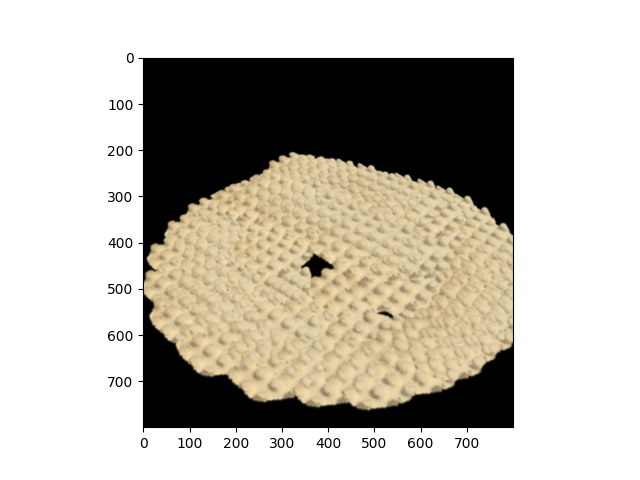

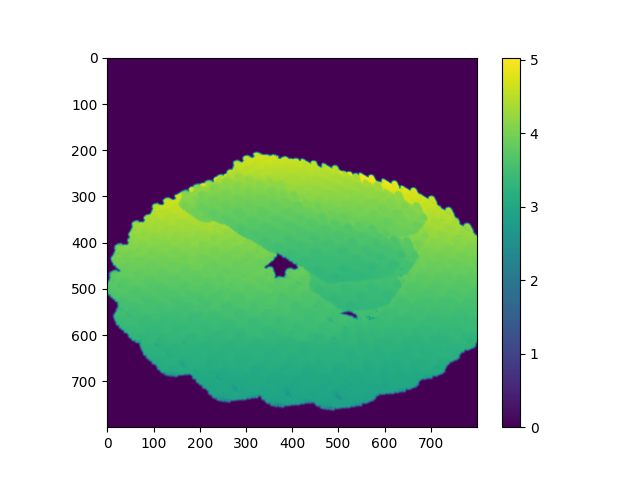

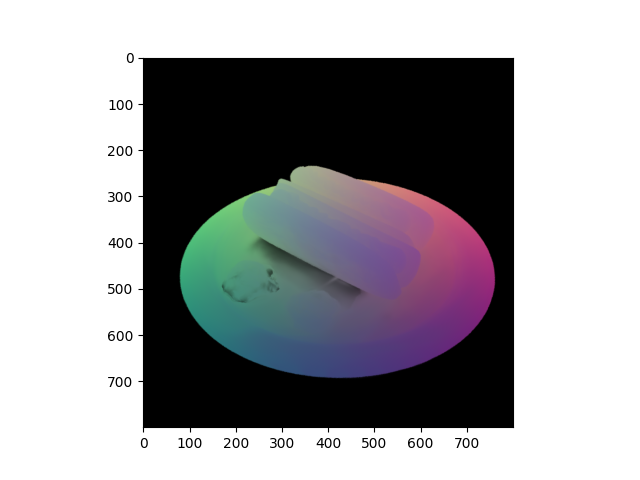

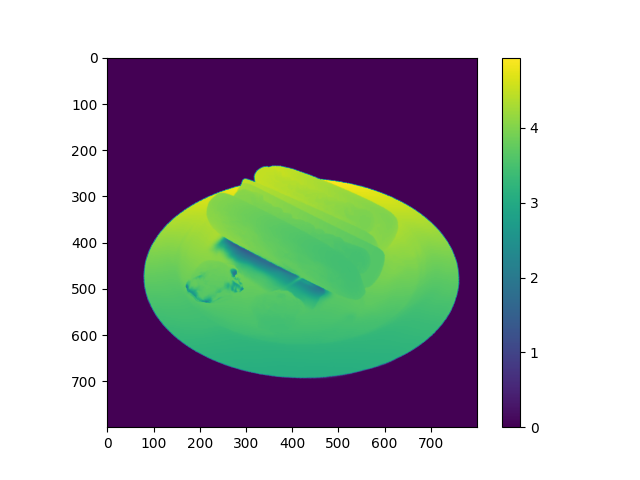

In [196]:
image_rgb = image.detach().cpu().numpy().transpose(1, 2, 0)
plt.figure()
plt.imshow(image_rgb)
plt.show()


depth_np = depth.detach().cpu().numpy()

plt.figure()
plt.imshow(depth_np)
plt.colorbar()
plt.show()

image_rgb = image_cont.detach().cpu().numpy().transpose(1, 2, 0)
plt.figure()
plt.imshow(image_rgb)
plt.show()


depth_np = depth_cont.detach().cpu().numpy()

plt.figure()
plt.imshow(depth_np)
plt.colorbar()
plt.show()

In [197]:

with torch.no_grad():
    gaussians_opt._features_dc.data = gaussians_opt._xyz.data.clone().detach().unsqueeze(1)
    gaussians_opt._features_rest.data = gaussians_opt._features_rest.data * 0.

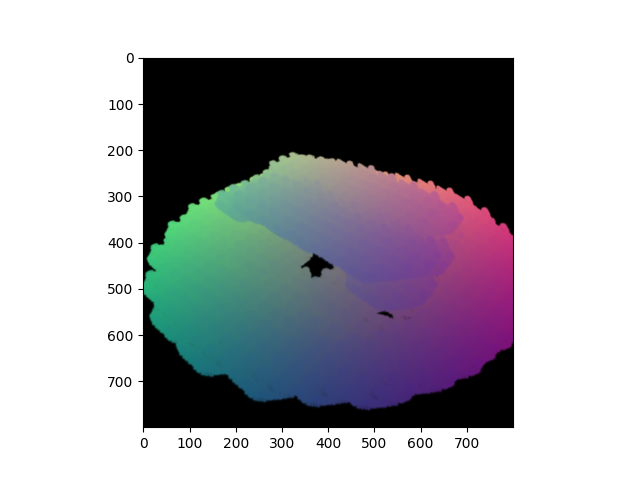

In [198]:

# Render
render_pkg = render(viewpoint_cam, gaussians_opt, pipe, background)
image, depth= render_pkg["render"], render_pkg["depth"]

image_rgb = image.detach().cpu().numpy().transpose(1, 2, 0)
plt.figure()
plt.imshow(image_rgb)
plt.show()


In [199]:

def get_descriptors(X, X_nns_indices):
    """
    Returns a matrix of distances between all points specified in the X_nns_indices matrix.
    :param X: tensor or shape [N,d]
    :param X_nns_indices: tensor of shape [N,k]
    :return 
        distances_nns : tensor of shape [N, k,k] with pairwise distances between all of the 
            k NNs for every sample in X.
    """
    
    X_nns = X[X_nns_indices]
    # All pairs can be too much
    # distances_nns = torch.norm(X_nns.unsqueeze(1) - X_nns.unsqueeze(2), dim=-1)
    # Just take all distances to the nearest neighbors
    distances_nns = torch.norm(X_nns[:,1:] - X_nns[:,0].unsqueeze(1), dim=-1)
    return distances_nns
    
def get_style_patch_descriptors_loss(clusters_to_opt_list, nns_indices, target_descriptor_cluster):
    """
    For every cluster of points in the clusters_to_opt_list we compute its descriptor of spatial 
    positions between all pairs of points within this cluster. Afterwards we compare this descriptor
    with the target descriptor.
    """
    loss_local_descriptor_list = []
    loss = 0.
    for cluster_points in clusters_to_opt_list:
        descriptor_points = get_descriptors(X=cluster_points, X_nns_indices=nns_indices)
        loss_local_descriptor = torch.mean(torch.square(descriptor_points - target_descriptor_cluster))
        loss += loss_local_descriptor 
        loss_local_descriptor_list.append(loss_local_descriptor)

    return loss / len(clusters_to_opt_list)


# now find initial desctiptors 

num_nns = 200
kth_nn = 20
num_nns_local = 100 # was 100
kth_nn_local = 1

distances = torch.cdist(gaussians_opt._xyz.data[:N], gaussians_opt._xyz.data[:N])
_, nns_indices = torch.topk(distances, k=num_nns, largest=False, dim=-1)

nns_indices = nns_indices[:, ::kth_nn]

target_descriptor_cluster = get_descriptors(X=gaussians_opt._xyz.data[:N], 
                                            X_nns_indices=nns_indices)
target_descriptor_cluster = target_descriptor_cluster.clone().detach()
target_descriptor_cluster.shape


torch.Size([2714, 9])

In [200]:


get_style_patch_descriptors_loss(clusters_to_opt_list=[gaussians_opt._xyz[:N]],
                                 nns_indices=nns_indices,
                                 target_descriptor_cluster=target_descriptor_cluster)



tensor(0., device='cuda:0', grad_fn=<DivBackward0>)

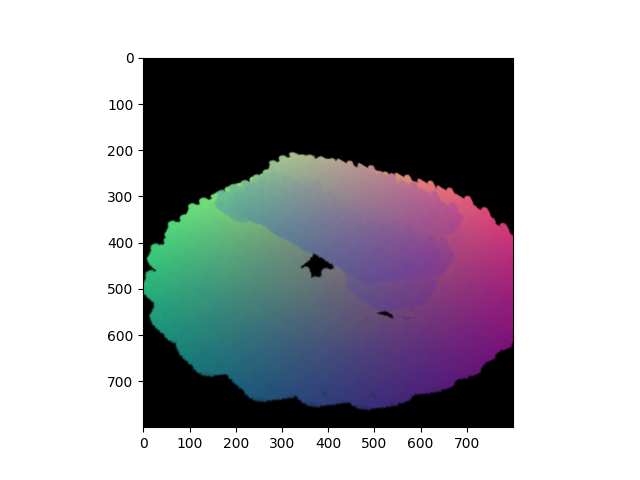

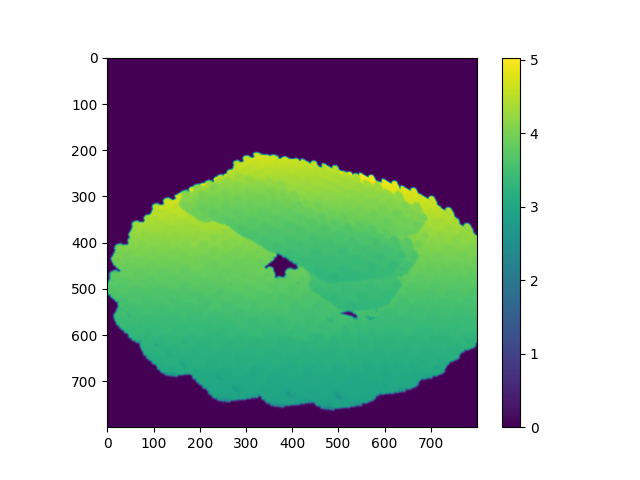

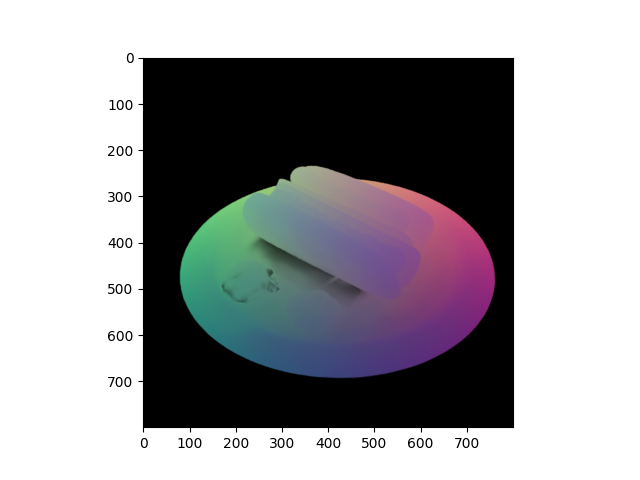

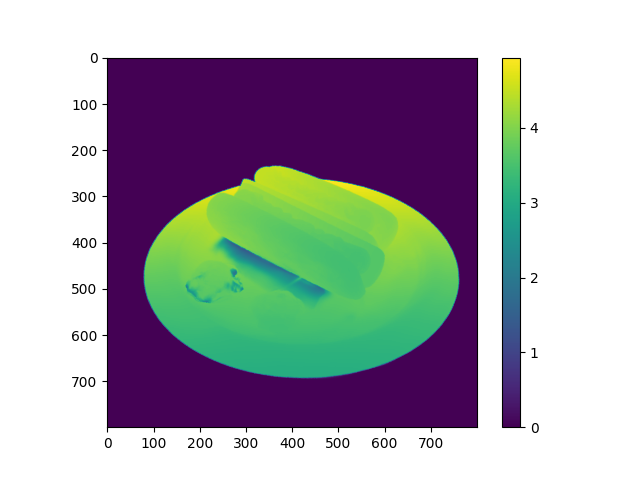

In [201]:
# Render
render_pkg = render(viewpoint_cam, gaussians_opt, pipe, background)
image, depth= render_pkg["render"], render_pkg["depth"]
render_pkg_cont = render(viewpoint_cam, content_gaussians, pipe, background)
image_cont, depth_cont= render_pkg_cont["render"], render_pkg_cont["depth"]


# Visualize
image_rgb = image.detach().cpu().numpy().transpose(1, 2, 0)
plt.figure()
plt.imshow(image_rgb)
plt.show()
depth_np = depth.detach().cpu().numpy()
plt.figure()
plt.imshow(depth_np)
plt.colorbar()
plt.show()
image_rgb = image_cont.detach().cpu().numpy().transpose(1, 2, 0)
plt.figure()
plt.imshow(image_rgb)
plt.show()
depth_np = depth_cont.detach().cpu().numpy()
plt.figure()
plt.imshow(depth_np)
plt.colorbar()
plt.show()

In [202]:
def calculate_ema(values, alpha=0.01):
    ema = [values[0]]  # Initial value is the same as the first value in the list

    for i in range(1, len(values)):
        ema.append(alpha * values[i] + (1 - alpha) * ema[-1])

    return ema


def l1_loss(network_output, gt):
    return torch.abs((network_output - gt)).mean()


def tv_loss(img):
    return 0.5 * (torch.abs(img[..., 1:, :] - img[..., :-1, :]).mean() +
                  torch.abs(img[..., :, 1:] - img[..., :, :-1]).mean())



In [203]:
losses_full=[]
losses_pixel = []
losses_reg = []
losses_tv = []
losses_loc_descr = []


gaussians_opt.training_setup(opt)
# for param_group in gaussians_opt.optimizer.param_groups:
#         param_group['lr'] = 1e-4


gaussians_opt._xyz.requires_grad = True
gaussians_opt._features_dc.requires_grad = True
gaussians_opt._features_rest.requires_grad = False
gaussians_opt._scaling.requires_grad = False
gaussians_opt._rotation.requires_grad = False
gaussians_opt._opacity.requires_grad = False
gaussians_opt.max_radii2D.requires_grad = False


In [204]:
gaussians_opt._scaling

Parameter containing:
tensor([[-5.0764, -5.0758, -5.0765],
        [-5.0767, -5.0758, -5.0759],
        [-5.0759, -5.0761, -5.0764],
        ...,
        [-5.0764, -5.0759, -5.0761],
        [-5.0759, -5.0765, -5.0761],
        [-5.0764, -5.0764, -5.0758]], device='cuda:0')

In [233]:

# Random sampling viewpoint



# def loss_to_depth_target(d, d_trg):
#     return torch.mean(torch.square(d - d_trg) * (d_trg>0.5))

def loss_to_depth_target(d, d_trg):
    return torch.mean(torch.square(d - d_trg))


from torchvision.transforms import v2
blurrer = v2.GaussianBlur(kernel_size=(31, 31), sigma=(30., 30.))


def loss_to_depth_target(d, d_trg, make_BG_large=False, blur_depth=False, blr_sgm=1.):
    d_ = d
    d_trg_ = d_trg
    if make_BG_large:
        d_trg_ = d_trg_ + (d_trg_<1e-2) * 1e2
    if blur_depth:
        d_ = gaussian_filter_2d(d_, sigma=blr_sgm)
        d_trg_ = gaussian_filter_2d(d_trg_, sigma=blr_sgm)
    return torch.mean(torch.square(d_ - d_trg_))# * (d_trg>0.01))

def renorm_cluster(cluster):
    """
    Provided a cluster of coordinates center it and normalize
    """
    return (cluster - torch.mean(cluster, dim=-1, keepdim=True)) / torch.std(cluster, dim=-1, keepdim=True)
    
if True:
    for step in tqdm(range(5001)):
        gaussians_opt.optimizer.zero_grad()
        # Pick a random Camera
        
        if not viewpoint_stack:
            viewpoint_stack = scene_opt.getTrainCameras().copy()
        
        # if step < 2:
        viewpoint_cam = viewpoint_stack.pop(randint(0, len(viewpoint_stack)-1))
        # Optimization gaussians
        render_pkg = render(viewpoint_cam, gaussians_opt, pipe, background)
        image, depth= render_pkg["render"], render_pkg["depth"]
        # Content gaussians
        render_pkg_cont = render(viewpoint_cam, content_gaussians, pipe, background)
        image_cont, depth_cont= render_pkg_cont["render"], render_pkg_cont["depth"]

        depth_target = depth_cont.clone().detach().to(device=device)

        
        # loss_descriptor_local = get_style_patch_descriptors_loss(
        #     clusters_to_opt_list=[renorm_cluster(gaussians_opt._xyz[i*N:(i+1)*N]) 
        #                           for i in range(C)],
        #     nns_indices=nns_indices,
        #     target_descriptor_cluster=target_descriptor_cluster)
        loss_descriptor_local = get_style_patch_descriptors_loss(
            clusters_to_opt_list=[gaussians_opt._xyz[i*N:(i+1)*N] for i in range(C)],
            nns_indices=nns_indices,
            target_descriptor_cluster=target_descriptor_cluster)


        #loss_pixel = torch.mean(torch.square(image - image_cont))
        loss_pixel = l1_loss(image, image_cont)
        loss_depth = l1_loss(depth, depth_cont)
        l_tv = tv_loss(image)
        l_reg = torch.mean(torch.square(gaussians_opt._xyz.unsqueeze(1) - gaussians_opt._features_dc))
        
        # loss = loss_pixel * 1e0  + l_tv * 1e-5 + l_reg * 1e1 + loss_descriptor_local * 1e3# tv_loss weight was 1e-3
        # loss = loss_pixel * 1e0  + l_tv * 1e-5 + l_reg * 1e1 + loss_descriptor_local * 1e0# tv_loss weight was 1e-3
        # loss = loss_pixel * 1e0  + l_tv * 1e-5 + l_reg * 1e1 + loss_descriptor_local * 1e1# tv_loss weight was 1e-3
        # Stage 1 
        # loss = loss_pixel * 1e0  + l_tv * 1e-5 + l_reg * 1e1 + loss_descriptor_local * 1e-4
        # Stage 2 
        # loss = loss_pixel * 1e0  + l_tv * 1e-5 + l_reg * 1e1 + loss_descriptor_local * 1e-3
        # # Stage 3
        # loss = loss_pixel * 1e0  + l_tv * 1e-5 + l_reg * 1e1 + loss_descriptor_local * 1e-1
        # # Stage 4
        # loss = loss_pixel * 1e0  + l_tv * 1e-5 + l_reg * 1e1 + loss_descriptor_local * 1e0
        # Stage 5
        # loss = loss_pixel * 1e0  + l_tv * 1e-5 + l_reg * 1e1 + loss_descriptor_local * 1e2
        #loss = loss_pixel * 1e0  + l_tv * 1e-5 + l_reg * 1e1 #+ loss_descriptor_local * 1e-4
        
        # loss = loss_pixel * 1e0  + l_tv * 1e-5 + l_reg * 1e1 + loss_descriptor_local * 1e3
        # loss = loss_pixel * 1e0  + l_tv * 1e-5 + l_reg * 1e1 + loss_descriptor_local * 1e4
        loss = loss_pixel * 5e0  + l_tv * 1e-5 + l_reg * 1e1 + loss_descriptor_local * 1e4
        # loss = loss_depth
        loss.backward()
    
        gaussians_opt.optimizer.step()
        losses_full.append(float(loss.detach().cpu().numpy()))
        losses_pixel.append(float(loss_pixel.detach().cpu().numpy()))
        losses_reg.append(float(l_reg.detach().cpu().numpy()))
        losses_tv.append(float(l_tv.detach().cpu().numpy()))
        losses_loc_descr.append(float(loss_descriptor_local.detach().cpu().numpy()))
  
    

        
        if step % 100 == 0:
            print(f"l_reg:{l_reg:.7f}, loss_descriptor_local:{loss_descriptor_local:.7f},",
                  f"l_tv:{l_tv:.7f}, loss_pixel:{loss_pixel:.7f}, loss:{loss:.7f}")

   



/tmp/ipykernel_3496546/530292088.py:33: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for step in tqdm(range(5001)):


  0%|          | 0/5001 [00:00<?, ?it/s]

l_reg:0.0122440, loss_descriptor_local:0.0000012, l_tv:0.0020160, loss_pixel:0.0229034, loss:0.2492280
l_reg:0.0017257, loss_descriptor_local:0.0000008, l_tv:0.0019055, loss_pixel:0.0143426, loss:0.0966558
l_reg:0.0004400, loss_descriptor_local:0.0000007, l_tv:0.0011085, loss_pixel:0.0053460, loss:0.0377623
l_reg:0.0002102, loss_descriptor_local:0.0000007, l_tv:0.0021084, loss_pixel:0.0114094, loss:0.0660264
l_reg:0.0001567, loss_descriptor_local:0.0000007, l_tv:0.0013914, loss_pixel:0.0046177, loss:0.0314208
l_reg:0.0001359, loss_descriptor_local:0.0000006, l_tv:0.0012493, loss_pixel:0.0056285, loss:0.0358499
l_reg:0.0001116, loss_descriptor_local:0.0000006, l_tv:0.0012399, loss_pixel:0.0039218, loss:0.0267304
l_reg:0.0001126, loss_descriptor_local:0.0000006, l_tv:0.0010888, loss_pixel:0.0043689, loss:0.0290756
l_reg:0.0001354, loss_descriptor_local:0.0000006, l_tv:0.0015385, loss_pixel:0.0047600, loss:0.0314306
l_reg:0.0001239, loss_descriptor_local:0.0000006, l_tv:0.0013002, loss_pi

KeyboardInterrupt: 

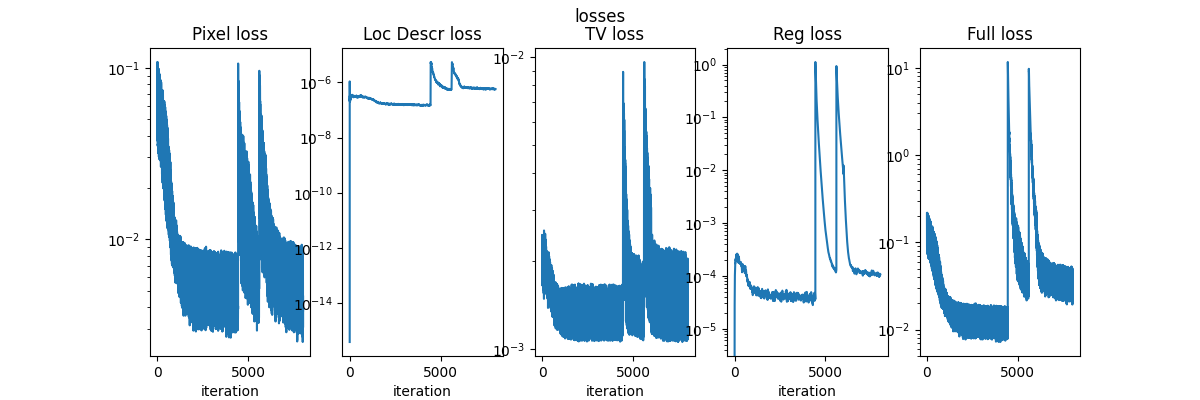

In [234]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(12,4))
fig.suptitle("losses")
ax[0].set_title("Pixel loss")
ax[0].plot(losses_pixel)
ax[0].set_yscale('log')
ax[1].set_title("Loc Descr loss")
ax[1].plot(losses_loc_descr)
ax[1].set_yscale('log')

ax[2].set_title("TV loss")
ax[2].plot(losses_tv)
ax[2].set_yscale('log')
ax[3].set_title("Reg loss")
ax[3].plot(losses_reg)
ax[3].set_yscale('log')
ax[4].set_title("Full loss")
ax[4].plot(losses_full)
ax[4].set_yscale('log')

for i in range(4): ax[i].set_xlabel("iteration")

plt.show()

In [235]:
gaussians_opt_features_dc_fitted = gaussians_opt._features_dc.data.detach().clone()

In [251]:
gaussians_opt._features_dc.data = gaussians_opt_features_dc_original.clone()

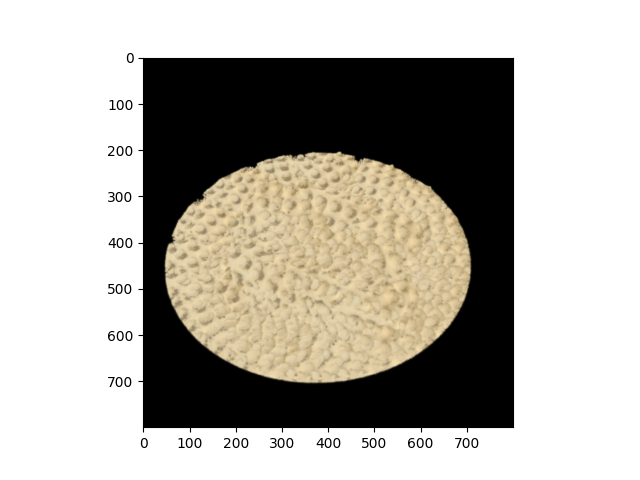

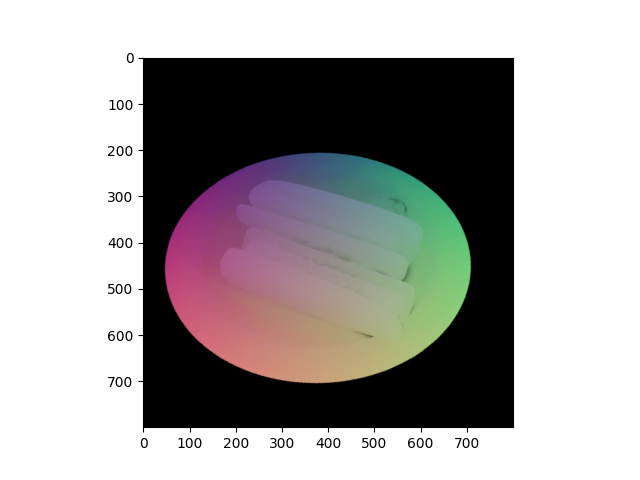

In [255]:
# Sample camera
viewpoint_stack = scene_opt.getTrainCameras().copy()
viewpoint_cam = viewpoint_stack.pop(randint(0, len(viewpoint_stack)-1))


# Render
render_pkg = render(viewpoint_cam, gaussians_opt, pipe, background)
image, depth= render_pkg["render"], render_pkg["depth"]
render_pkg_cont = render(viewpoint_cam, content_gaussians, pipe, background)
image_cont, depth_cont= render_pkg_cont["render"], render_pkg_cont["depth"]


# Visualize
image_rgb = image.detach().cpu().numpy().transpose(1, 2, 0)
plt.figure()
plt.imshow(image_rgb)
plt.show()
# depth_np = depth.detach().cpu().numpy()
# plt.figure()
# plt.imshow(depth_np)
# plt.colorbar()
# plt.show()
image_rgb = image_cont.detach().cpu().numpy().transpose(1, 2, 0)
plt.figure()
plt.imshow(image_rgb)
plt.show()
# depth_np = depth_cont.detach().cpu().numpy()
# plt.figure()
# plt.imshow(depth_np)
# plt.colorbar()
# plt.show()

In [232]:
gaussians_opt._features_dc.data = gaussians_opt_features_dc_fitted.clone()

In [256]:
import sys
sys.path.append("../")

from scene import GaussianModel
MODEL_DIR = './GT_lego_cluster2/'
MODEL_DIR_NEW = './GT_hotdog_lego_ntbk19_save2/'
os.makedirs(MODEL_DIR_NEW, exist_ok = True)

! cp -r {MODEL_DIR}* {MODEL_DIR_NEW}
# ls MODEL_DIR




In [257]:

iteration=1
torch.save((gaussians_opt.capture(), iteration), MODEL_DIR_NEW + "/chkpnt" + str(iteration) + ".pth")
gaussians_opt.save_ply(os.path.join(MODEL_DIR_NEW, "point_cloud/iteration_1/", "point_cloud.ply"))


In [258]:

def find_overlapping_gaussians(domain, points_list, eps=1e-2):
    # Find centers of every cluster listed in the points_list
    centroids_list = torch.stack([torch.mean(points, dim=0) for points in points_list], axis=0)
    print("1:")
    print(centroids_list)
    # For each domain point find the nearest cluster index from the points_list
    domain_to_centroid_idx = torch.argmin(torch.torch.cdist(domain, centroids_list), dim=-1)
    print("2:")
    print(domain_to_centroid_idx)
    # now compute distance from every point from each cluster from the points_list to the nearest domain points index
    
    points_list_to_domain = []
    for points in points_list:
        
        points_to_domain = torch.argmin(torch.torch.cdist(points, domain), dim=-1)
        points_list_to_domain.append(points_to_domain)
    print("3:")
    print(points_list_to_domain)
    # Find indices of points from each element of the points_list to retain. 
    points_list_idcs_to_retain = []
    for points_idx, points_to_domain in enumerate(points_list_to_domain):
        print("points_to_domain[domain_to_centroid_idx]:")
        print(points_to_domain[domain_to_centroid_idx])
        idcs_to_retain = torch.where(domain_to_centroid_idx[points_to_domain] == points_idx)[0]
        print("idcs_to_retain:",idcs_to_retain)
        points_list_idcs_to_retain.append(idcs_to_retain)

    return points_list_idcs_to_retain


In [259]:
content_gaussians._xyz.data

tensor([[ 0.1638,  0.6257,  0.2065],
        [-0.2366,  0.7300, -0.0360],
        [-0.5879,  0.7040, -0.1055],
        ...,
        [ 1.1910, -0.0534, -0.0731],
        [-0.4296,  0.7755, -0.0624],
        [-0.4950,  0.7393, -0.0601]], device='cuda:0')

In [260]:

gaussians_opt_idcs_to_retain = find_overlapping_gaussians(domain=content_gaussians._xyz.data, 
                                                          points_list=[gaussians_opt._xyz[i*N:(i+1)*N] for i in range(C)])

1:
tensor([[ 2.2485e-01, -1.7790e-01,  1.0113e-01],
        [ 7.2015e-01,  2.6681e-01, -7.0401e-02],
        [-4.8573e-02,  4.5137e-01,  1.0384e-01],
        [-9.3714e-01,  1.1384e-03, -9.8262e-02],
        [ 6.7084e-01, -6.9307e-01, -9.6114e-02],
        [ 5.3686e-01,  5.1485e-01,  4.7551e-02],
        [-2.4756e-01,  7.8452e-01, -1.0794e-01],
        [ 9.3001e-01,  1.0711e-01, -1.0672e-01],
        [-3.0811e-03, -6.8353e-01, -4.7664e-02],
        [ 4.1360e-01,  1.4338e-02,  9.5094e-02],
        [ 9.0828e-01, -2.1773e-01, -1.1452e-01],
        [ 7.6471e-01,  4.7420e-01, -8.7133e-02],
        [ 3.5378e-01,  7.6925e-01, -7.6240e-02],
        [ 5.0351e-01, -2.0812e-01,  1.6028e-01],
        [-6.5447e-01, -7.4451e-01, -1.0751e-01],
        [ 3.7497e-01, -7.3771e-01, -1.3379e-01],
        [ 4.8398e-01,  2.5771e-01,  3.7907e-03],
        [ 2.6512e-01,  2.3721e-01,  1.4264e-01],
        [-4.0628e-01,  4.3069e-01, -1.2813e-01],
        [ 6.6864e-01,  5.9092e-01, -6.8506e-02],
        [ 5.7744e

In [261]:
gaussians_opt_idcs_to_retain_unlist = torch.concat([cluster_idcs + i * N for i, cluster_idcs in enumerate(gaussians_opt_idcs_to_retain)],
                                                  dim=0)

In [262]:
gaussians_opt_idcs_to_retain_unlist, len(gaussians_opt_idcs_to_retain_unlist)

(tensor([    10,     47,     52,  ..., 217105, 217112, 217113], device='cuda:0'),
 65649)

In [263]:
gaussians_opt._xyz.shape

torch.Size([217120, 3])

In [272]:

import sys
sys.path.append("../")

from scene import GaussianModel
MODEL_DIR = './GT_lego_cluster2/'
MODEL_DIR_NEW2 = './GT_hotdog_lego_ntbk19_save2_no_overlaps2/'
os.makedirs(MODEL_DIR_NEW2, exist_ok = True)

! cp -r {MODEL_DIR}* {MODEL_DIR_NEW2}
# ls MODEL_DIR




In [273]:
N, C

(2714, 80)

In [276]:
gaussians_to_save = GaussianModel(sh_degree=3)
# Store optimized parameters to the gaussias_to_save

gaussians_to_save._xyz.data = gaussians_opt._xyz.data[gaussians_opt_idcs_to_retain_unlist]
gaussians_to_save._rotation = gaussians_opt._rotation.data[gaussians_opt_idcs_to_retain_unlist]
gaussians_to_save._features_dc = gaussians_opt._features_dc.data[gaussians_opt_idcs_to_retain_unlist]
gaussians_to_save._features_rest = gaussians_opt._features_rest.data[gaussians_opt_idcs_to_retain_unlist]
gaussians_to_save._scaling =  gaussians_opt._scaling.data[gaussians_opt_idcs_to_retain_unlist]
gaussians_to_save._opacity =  gaussians_opt._opacity.data[gaussians_opt_idcs_to_retain_unlist]
print(gaussians_to_save._xyz.shape, 
      gaussians_to_save._rotation.shape,
      gaussians_to_save._features_dc.shape,
      gaussians_to_save._features_rest.shape,
      gaussians_to_save._scaling.shape,
      gaussians_to_save._opacity.shape,
     )
gaussians_to_save.max_radii2D.data = gaussians_opt.max_radii2D.data[gaussians_opt_idcs_to_retain_unlist]
gaussians_to_save.xyz_gradient_accum.data = gaussians_opt.xyz_gradient_accum.data[gaussians_opt_idcs_to_retain_unlist]
gaussians_to_save.denom.data = gaussians_opt.denom.data[gaussians_opt_idcs_to_retain_unlist]


# gaussians_to_save._xyz = gaussians_to_save._xyz * 0.4
# gaussians_to_save._scaling = gaussians_to_save._scaling * 1.1
gaussians_to_save._xyz = gaussians_to_save._xyz * 1.
gaussians_to_save._scaling = gaussians_to_save._scaling * 0.95
gaussians_to_save.training_setup(opt)

iteration=1
torch.save((gaussians_to_save.capture(), iteration), MODEL_DIR_NEW2 + "/chkpnt" + str(iteration) + ".pth")
gaussians_to_save.save_ply(os.path.join(MODEL_DIR_NEW2, "point_cloud/iteration_1/", "point_cloud.ply"))

torch.Size([65649, 3]) torch.Size([65649, 4]) torch.Size([65649, 1, 3]) torch.Size([65649, 15, 3]) torch.Size([65649, 3]) torch.Size([65649, 1])
